In [55]:
DATA_NAME = "playroom_23"
PIXEL_NUMBER = 678523

In [56]:
from os.path import join

from numpy import float32
from polars import Float32, Schema, UInt8, UInt32, scan_csv, all

from clustering_exploration.utils.constants import DATA_DIR, NUMBER_OF_SPLATS_PER_PIXEL

# Define the column names.
column_names = [
    f"gaussian_{i}_{part}" for i in range(NUMBER_OF_SPLATS_PER_PIXEL) for part in
    ["id", "alpha", "depth", "color_r", "color_g", "color_b"]
]
column_names = [
    "sample_index",
    "out_color_r",
    "out_color_g",
    "out_color_b",
    "background_r",
    "background_g",
    "background_b",
    *column_names,
]

# Define schema.
schema_dict = {name: Float32 for name in column_names}
schema_dict["sample_index"] = UInt32
schema_dict["background_r"] = UInt8
schema_dict["background_g"] = UInt8
schema_dict["background_b"] = UInt8
schema = Schema(schema_dict)

# Load the data from CSV.
data_path = join(DATA_DIR, f"{DATA_NAME}.csv")
raw_data = scan_csv(data_path, schema=schema)

# Extracts the splats.
id_splats = (
    raw_data.select(
        all().exclude(
            "sample_index",
            "out_color_r",
            "out_color_g",
            "out_color_b",
            "background_r",
            "background_g",
            "background_b",
        )
    )
    .slice(PIXEL_NUMBER, 1)
    .collect()
    .to_numpy()
    .astype(float32, copy=False)
    .reshape((NUMBER_OF_SPLATS_PER_PIXEL, 6))
)


In [57]:
transmittances = [1]

current_transmittance = 1
for splat_id, alpha, *splat_data in id_splats:
    if alpha == 0:
        break
    current_transmittance *= (1 - alpha)
    transmittances.append(current_transmittance)

# Remove the last transmittance which is 0.
transmittances.pop()

np.float32(0.003294606)

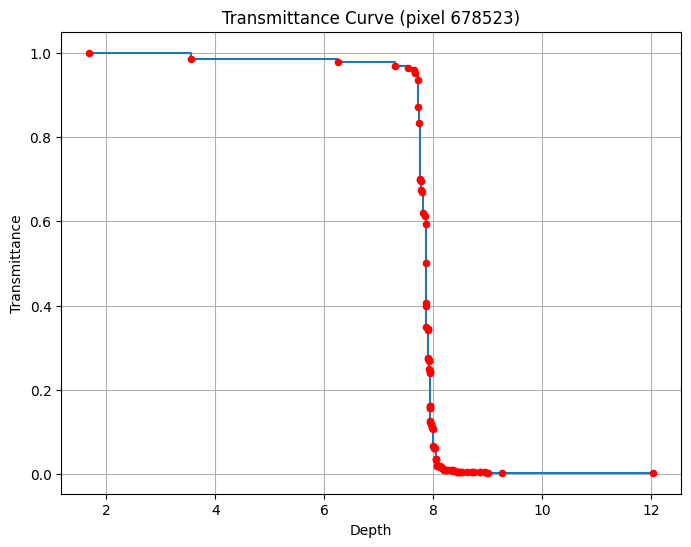

In [58]:
import matplotlib.pyplot as plt

depth = id_splats[:, 2]

plt.figure(figsize=(8, 6))
plt.step(depth[:len(transmittances)], transmittances, where='post')
plt.scatter(depth[:len(transmittances)], transmittances, color='red', s=20, zorder=3, label='Data Points')
plt.xlabel('Depth')
plt.ylabel('Transmittance')
plt.title(f'Transmittance Curve (pixel {PIXEL_NUMBER})')
plt.grid(True)
plt.savefig(f"output/curve_{PIXEL_NUMBER}.png", dpi=600, bbox_inches='tight')